In [1]:
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
mongo = client.hai

In [2]:
import time

start_time = 1513487106-3600*24*5
end_time = 1513487106-3600*24*1
#start_time = 1513487106
#end_time = 1513487106+3600+60*9
username = "sean"
print(start_time, end_time)

1513055106 1513400706


In [3]:
query = {"user_name": username, "pose":{"$exists": True}, "detections":{"$exists": True}, "time": {"$gt": start_time, "$lt": time.time()}}
cams = mongo.images.find(query).distinct("cam_id")
print(cams)
cams = ['webcam0']

['webcam0', 'nakacam0', 'nakacam1']


In [4]:
import os
import sys

sys.path.append("..")
os.chdir("/home/sean/HAI/main_server/hai")

In [5]:
%load_ext autoreload
%autoreload 2
from controllers.dbreader.imagereader import ImageReader

In [6]:
imreader = ImageReader()
imdata, times = imreader.read_db(username, start_time, end_time, cams, skip_absent=True)

In [7]:
len(imdata)

12616

In [8]:
from controllers.vectorizer.person2vec import Person2Vec
data2vec = Person2Vec()
pose_mat, act_mat, meta = data2vec.vectorize(imdata, get_meta=True)

In [9]:
print(pose_mat.shape, act_mat.shape)

(12616, 54) (12616, 1024)


In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import numpy as np

%matplotlib inline

def plot(x):
    pca = PCA(n_components=50)
    tsne = TSNE(n_components=2)
    pipe = Pipeline([("std", StandardScaler()), ("pca", pca), ("tsne", tsne)])
    x = pipe.fit_transform(x)
    #for t in range(start_time, end_time, 3600):
    #cond = np.where(np.logical_and(time_data2>t, time_data2<=t+3600))
    #plt.scatter(x[cond,0],x[cond,1], label=t)
    plt.scatter(x[:,0], x[:, 1])
    plt.show()
    return x, pipe
    
mask = np.arange(4000, 5000)

start_time = time.time()
com_X_raw = np.concatenate([act_mat, pose_mat], axis=1)
#mask = np.intersect1d(mask, np.where(np.sum(com_X_raw == 0, axis=1) < 54))
#import pickle
#mask = pickle.load(open("mask.pkl", "rb"))
com_X = com_X_raw[mask, :]

In [11]:
%matplotlib inline
from skimage.measure import compare_ssim as ssim
import cv2

def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    return err

prev = None
diffs_raw = []

for i, imd in enumerate(np.array(imdata)[mask]):
    img = plt.imread("images/raw_images/" + imd[0]["filename"])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if prev is not None:
        #diff = mse(img, prev)
        diff = ssim(img, prev)
        diffs_raw.append(diff)
        if i % 100 == 0:
            print(i)
        
    prev = img

#std = StandardScaler()
#tx = std.fit_transform(com_X)
#img = np.sum((tx[1:, 1024:].T - tx[:-1, 1024:].T)**2.0, axis=0)
#print(np.where(img > 500))

100
200
300
400
500
600
700
800
900


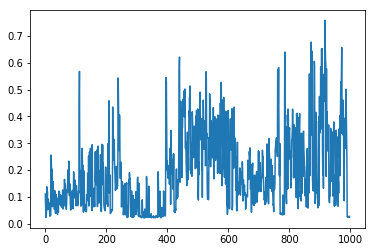

In [12]:
diffs = 1.0 - np.array(diffs_raw)
plt.plot(np.array(diffs))

(1000, 1024)


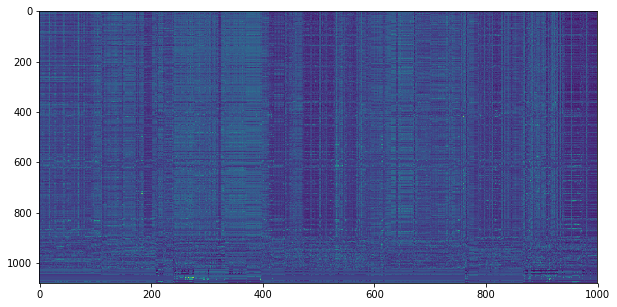

In [13]:
plt.figure(figsize = (10,5))
print(com_X[:, :1024].shape)
plt.imshow(StandardScaler().fit_transform(com_X).T, aspect='auto')

In [14]:
import ruptures as rpt

# change point detection
model = "l1"  # "l2", "rbf"
algo = rpt.BottomUp(model=model, min_size=1, jump=1).fit(com_X)
my_bkps = algo.predict(pen=np.log(len(com_X))*1024*2**2)
print(my_bkps)

[113, 210, 222, 240, 277, 327, 371, 396, 413, 442, 472, 531, 632, 671, 763, 788, 882, 931, 956, 964, 1000]


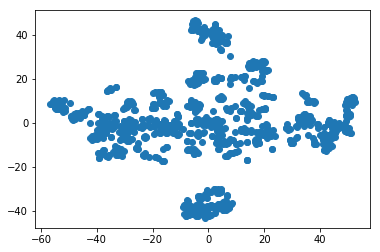

time taken 110.87813067436218
(1000, 1078)


In [15]:
com_X2, com_pipe = plot(com_X)
#pose_X, pose_pipe = plot(pose_mat[mask])
#act_X, act_pipe = plot(act_mat[mask])
print("time taken", time.time() - start_time)
print(com_X.shape)

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def fit_model1(x, labeled_x, y):
    clf = LogisticRegression(C=1.0)
    
    pca = PCA(n_components=10)
    std = StandardScaler()
    
    x2 = std.fit_transform(x)
    pca.fit_transform(x2)
    clf.fit(pca.transform(std.transform(labeled_x)), y)
    
    pipe = Pipeline([("std", std), ("pca", pca), ("nn", clf)])
    return pipe.predict_proba(x)

def fit_model2(x, labeled_x, y):
    clf = KNeighborsClassifier(3, weights='distance')
    
    pca = PCA(n_components=10)
    std = StandardScaler()
    
    x2 = std.fit_transform(x)
    pca.fit_transform(x2)
    clf.fit(pca.transform(std.transform(labeled_x)), y)
    
    pipe = Pipeline([("std", std), ("pca", pca), ("nn", clf)])
    return pipe.predict_proba(x)

def fit_model3(x, labeled_x, y):
    clf = KNeighborsClassifier(1, weights='distance')
    
    std = StandardScaler()
    x2 = std.fit_transform(x)
    clf.fit(std.transform(labeled_x), y)
    
    pipe = Pipeline([("std", std), ("nn", clf)])
    return pipe.predict(x)

def fit_model4(x, labeled_x, y):
    clf = RandomForestClassifier(n_estimators=20)
    clf.fit(labeled_x, y)
    return clf.predict(x), clf.predict_proba(x)

In [17]:
from notebooks.utils.utils import ImageUpdater
import matplotlib.animation as animation

%matplotlib nbagg

labels = []
for i in range(len(imdata)):
    if i == 4352:
        labels.append("phone")
    elif i == 4163 or i == 4593:
        labels.append("work")
    else:
        labels.append("etc")

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)[mask]

etc_mask = le.transform(["etc"])[0]
etc_mask = labels != etc_mask

## - add labels
where = np.where(etc_mask)[0]
clusters = np.searchsorted(my_bkps, where)
for i, c in enumerate(clusters):
    labels[my_bkps[c-1]:my_bkps[c]] = labels[where[i]]
    
etc_i = le.transform(["etc"])[0]
etc_mask = labels != etc_i
## --

preds, probs = fit_model4(com_X, com_X[etc_mask], labels[etc_mask])
predictions = []
for i, p in enumerate(probs):
    if np.max(p) > 0.7:
        predictions.append(preds[i])
    else:
        predictions.append(etc_i)
        
predictions = probs# + 1np.array(probs)
#certainty = np.max(probs, axis=1)

<IPython.core.display.Javascript object>


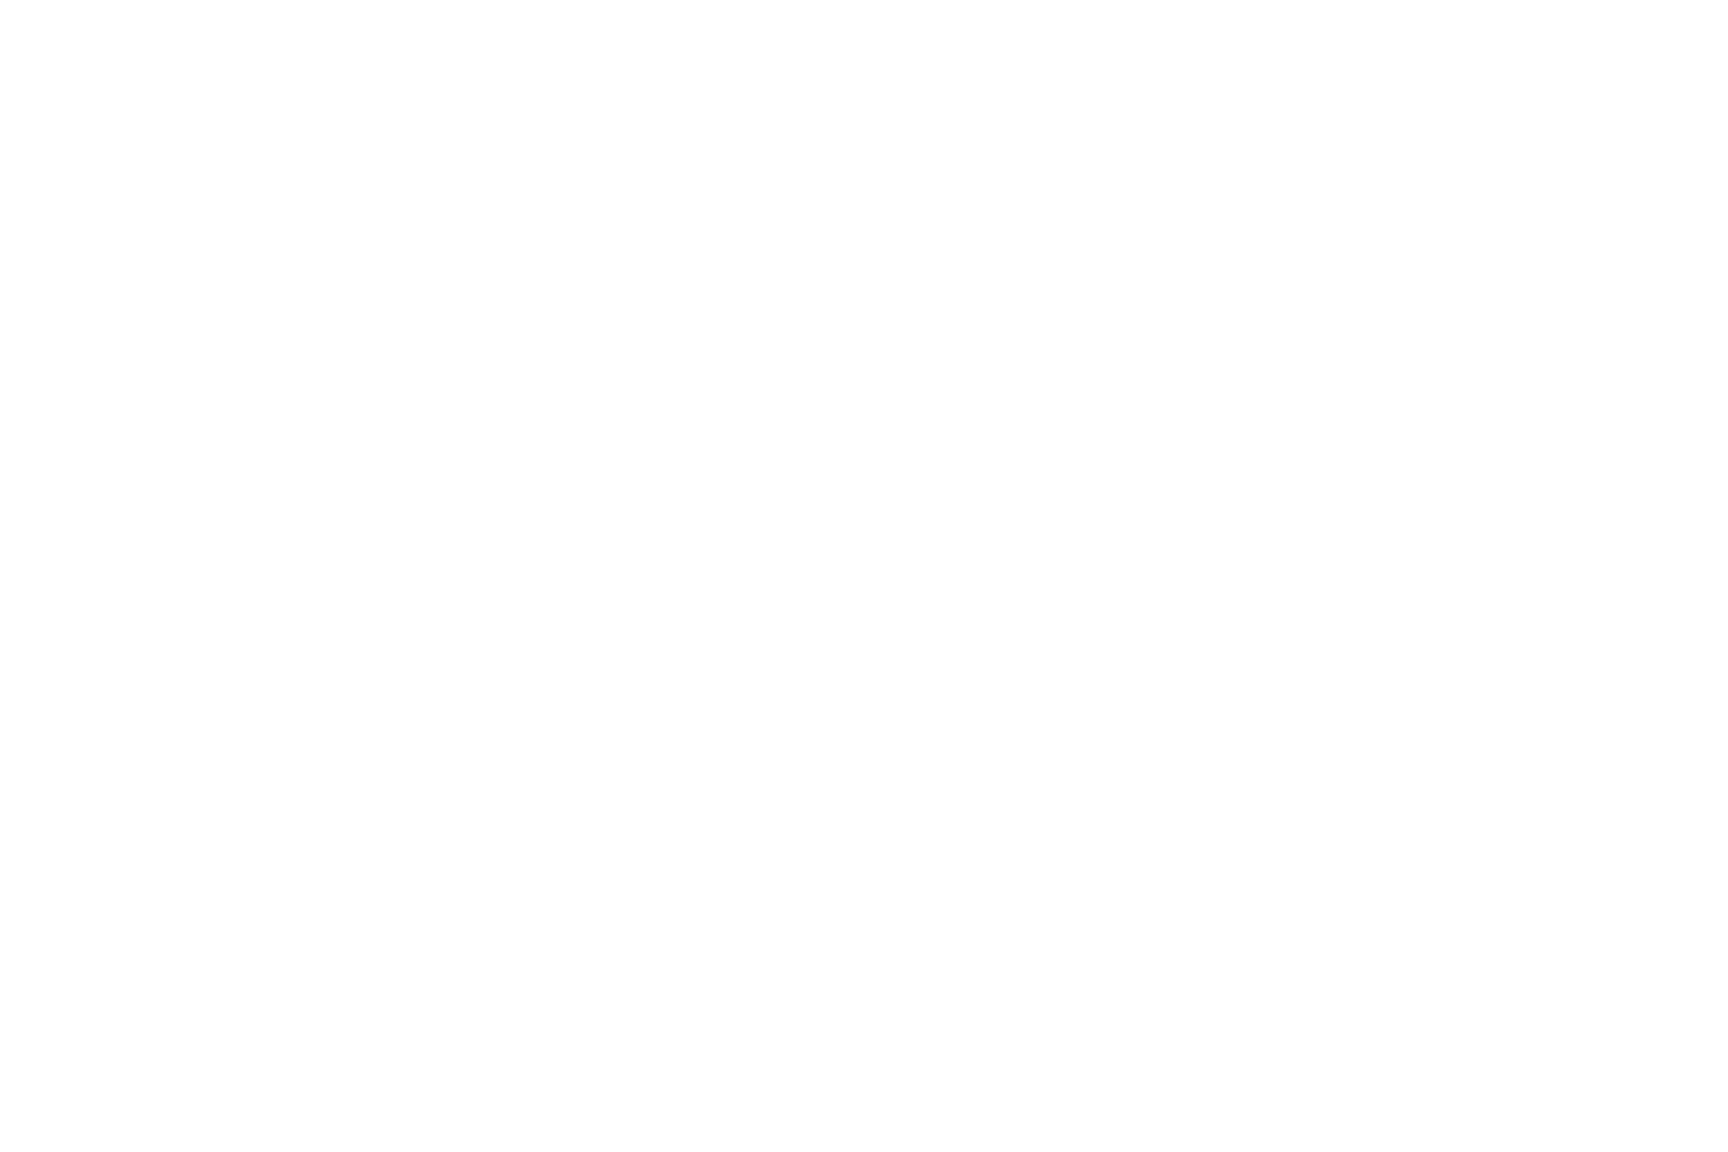

0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


<IPython.core.display.Javascript object>


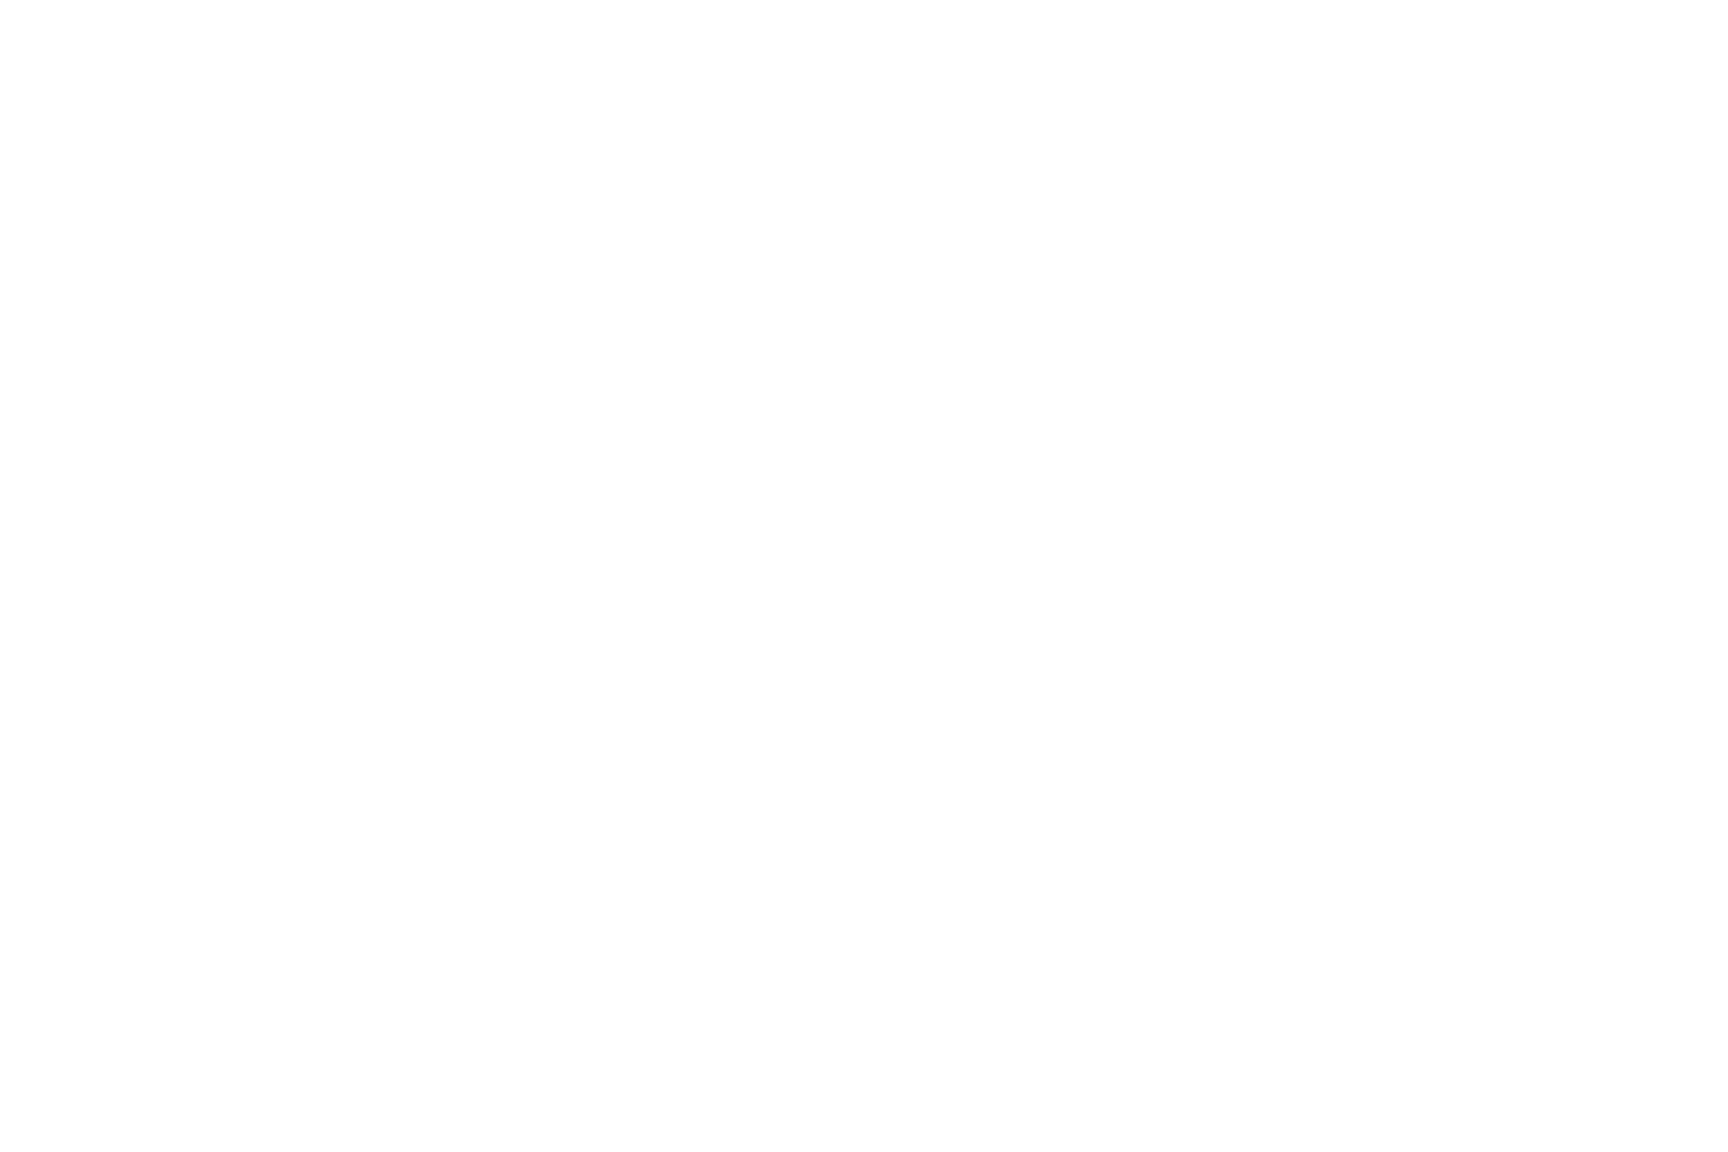

Traceback (most recent call last):
  File "/home/sean/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 389, in process
    proxy(*args, **kwargs)
  File "/home/sean/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "/home/sean/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/animation.py", line 1560, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [18]:
fig, axes = plt.subplots(3, max(len(cams), 3), figsize=(12,8), squeeze=False)
skip=10
updater = ImageUpdater(axes, np.array(imdata)[mask], None, None, com_X2, np.array(meta)[mask], labels, predictions, le.classes_, diffs, mask, my_bkps, skip=skip)
fig.tight_layout()
ani = animation.FuncAnimation(fig, updater, frames=range(0, len(com_X), skip), interval=100, repeat=False)
ani.save('test.mp4', writer="ffmpeg")